In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf

import pixiedust
from functools import partial
import gin
import itertools
import multiprocessing
import pickle

from synthetic_data import xs_e, ys_e, Q1, xs, ys, A
from synthetic_experiment import projection_simplex_sort, arr_of_dicts_to_dict_of_arrays
from tqdm.notebook import tqdm
import math
import seaborn as sns

Pixiedust database opened successfully


In [8]:
# defining the model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=(4,), use_bias=False)
    ])
    return model

# learning rate
lr = 1e-3

# number of epochs
epochs = 2000

# training batch size
batch_size = 128

# maximum weight norm
l1_ball_size = 5

# data
X = xs
Y = ys

In [9]:
# creating an optimizer
optimizer = tf.keras.optimizers.Adam(lr=lr)

In [10]:
def project_l1(v, z=1):
    """Project onto |x|_1<=z."""
    v = np.array(v)
    signs = np.sign(v)
    v_unsigned = np.multiply(v, signs)
    u_unsigned = projection_simplex_sort(v_unsigned, z)
    u = np.multiply(u_unsigned, signs)
    norm = np.linalg.norm(u, ord=1)
    assert norm <= z * 1.1, "Got norm %.2f %s" % (norm, str(u))
    #assert np.allclose(np.linalg.norm(u, ord=1), 1)
    return u

@tf.function
def flatten_array_of_tensors(W):
    """Take an array of tensor and turn into a single flat tensor."""
    return tf.concat([tf.reshape(w, (-1,)) for w in W], axis=0)

def gradient_step(xs, ys, model, optimizer):
    """Do a gradient step."""
    
    xs = np.array(xs, dtype=np.float32)
    ys = np.array(ys, dtype=np.float32)
    
    with tf.GradientTape() as tape:
        y_pred = model(xs)
        delta = y_pred - ys
        delta_flat = flatten_array_of_tensors([delta])
        
        # using MAE
        loss = tf.reduce_mean(tf.abs(delta_flat))
        
        # l1 norm of weights
        loss_l1 = tf.reduce_sum(tf.abs(\
                    flatten_array_of_tensors(model.weights)))
    
    variables = model.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return {'fit': loss.numpy(), 'l1': loss_l1.numpy()}

def projection_step(model):
    """Project weights onto an l1 ball."""
    weights = model.trainable_variables[0]
    #w_flat = flatten_array_of_tensors(weights)
    w_numpy = weights.numpy()
    w_flat = np.reshape(w_numpy, (-1,))
    w_flat_new = project_l1(w_flat, l1_ball_size)
    norm = np.linalg.norm(w_flat_new, ord=1)
    w_flat_new = np.reshape(w_flat_new, w_numpy.shape)
    weights.assign(w_flat_new)
    return norm

def step(xs, ys, model, optimizer):
    """Optimize 1 step."""
    #print(model.weights)
    losses = gradient_step(xs, ys, model, optimizer)
    #print(model.weights)
    norm = projection_step(model)
    losses['l1'] = norm
    #print(model.weights)
    return losses

In [23]:
def plot_results(losses):
    """Plot losses."""
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:mint green')

    references = {'fit': 0, 'l1': l1_ball_size}

    for i, key in enumerate(losses.keys()):
        plt.subplot(1, len(losses) + 1, i + 1)
        plt.title(key)
        plt.plot(losses[key])
        plt.axhline(references[key], ls='--', c='black')
        
    plt.subplot(1, len(losses) + 1, len(losses) + 1)
    plt.title("Weights heatmap")
    sns.heatmap(model.weights[0].numpy())

    plt.show()

In [24]:
def train(model, optimizer, X, Y):
    """Train with batches."""
    losses = []

    batches_per_epoch = math.ceil(1. * len(X) / batch_size)

    for epoch in tqdm(range(epochs)):
        for batch in range(batches_per_epoch):
            n = batch * batch_size
            xs_b = X[n:n+batch_size]
            ys_b = Y[n:n+batch_size]
        l = step(xs_b, ys_b, model, optimizer)
        losses.append(l)
    losses = arr_of_dicts_to_dict_of_arrays(losses)
    return losses

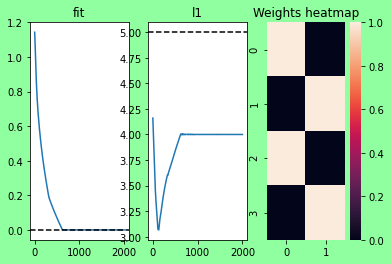

In [25]:
l1_ball_size = 5
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)

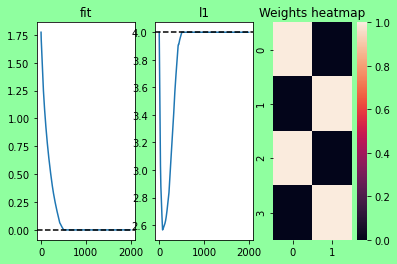

In [26]:
l1_ball_size = 4
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)

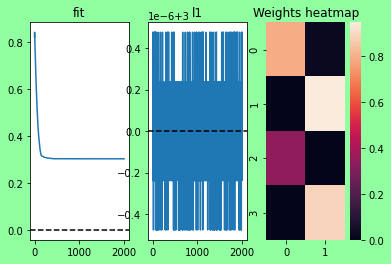

In [27]:
l1_ball_size = 3
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)

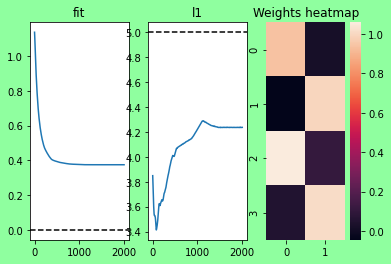

In [35]:
l1_ball_size = 5
model = build_model()
losses = train(model, optimizer, X, Y + np.random.normal(0, 0.5, Y.shape))
plot_results(losses)

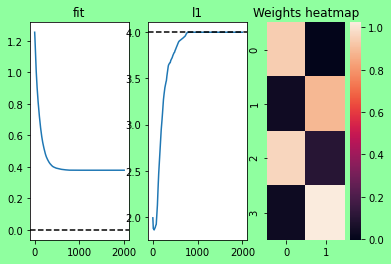

In [36]:
l1_ball_size = 4
model = build_model()
losses = train(model, optimizer, X, Y + np.random.normal(0, 0.5, Y.shape))
plot_results(losses)

In [ ]:
mas